# Thermal camera project overview

---


What we're going to do in this project?


*   Read collected images into python
*   Create preprocessing function for our data
*   Build neural network model
*   Feed data into the model and start training
*   Compare traning results and the groudtruth

# Step 1: Data loading

In [ ]:
# import python libraries
import cv2
import os
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check current working directory, make sure the data is stored in the directory
os.getcwd()

'/content/drive/.shortcut-targets-by-id/10ka7G--xYdG6spAfyX54VALZMhUm-eec/Digital imaging project/Thermal/data'

In [ ]:
# change working directory to the data folder
os.chdir('/content/drive/MyDrive/Digital imaging project/Thermal/data')

In [ ]:
# define the image loading function and resize all images to the same size
def load_images_from_folder(folder, target_size = (256, 256)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 3)
        b,g,r = cv2.split(img)           # get b, g, r, cv2 uses bgr so we need to switch it to rgb
        img = cv2.merge([r,g,b])     # switch it to r, g, b
        img = np.array(img)
  
        if folder == "RGB":
            #zoom in image
            new_rgb = np.zeros((340, 440, 3), dtype=np.uint8)
            for i in range(40, img.shape[0]-100):
              for j in range(110, img.shape[1]-90):
                new_rgb[i-40, j-110, :] = img[i, j, :]
            new_rgb = cv2.resize(new_rgb, (640, 480), cv2.INTER_CUBIC) #notice that cv2.resize uses reversed order of image shape
            img = np.array(new_rgb, dtype='uint8')

        #reshape to target size
        h, w = img.shape[:2]
        c = img.shape[2] if len(img.shape) > 2 else 1
        if h == w:
            return cv2.resize(img, target_size, cv2.INTER_AREA)
        
        dif = h if h > w else w

        interpolation = cv2.INTER_AREA if dif > (target_size[0]+target_size[1])//2 else cv2.INTER_CUBIC

        x_pos = (dif - w)//2
        y_pos = (dif - h)//2

        if len(img.shape) == 2:
            mask = np.zeros((dif, dif), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        else:
            mask = np.zeros((dif, dif, c), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

        img1 = Image.open(os.path.join(folder,filename))
        new1 = cv2.resize(mask, target_size, interpolation)
        new1 = np.array(new1, dtype='uint8')
        images.append(new1)
    return images

In [ ]:
#load the two groups of images
thermal = load_images_from_folder("Thermal")

In [ ]:
gt = load_images_from_folder("RGB")

In [ ]:
#check if images are in the desired size
thermal[0].shape   #the first image

(256, 256, 3)

In [ ]:
gt[0].shape

(256, 256, 3)

# Step 2: Data pre-processing
* Split the dataset into training and testing sets 
- (The function train_test_split can do it automatically for us, the argument test_size means the proportion of testing set,
which is generally set as 0.2, and the random_state is the seed to ramdomly select testing images. We set the random_state because we want to reproduce the same data split everytime we run the code.)

#Create rotated images

In [ ]:
import imutils

In [ ]:
def Rotate(imgs, degree):
  """Take a list of images, rotate each of them by the degree 
  counterclockwise and output rotated images."""
  rotated_imgs = []
  for img in imgs:
    rotated_img = imutils.rotate(img, angle=degree)
    rotated_imgs.append(rotated_img)
  return rotated_imgs

In [ ]:
rotated_thermal = Rotate(thermal, 90)
rotated_gt = Rotate(gt, 90)

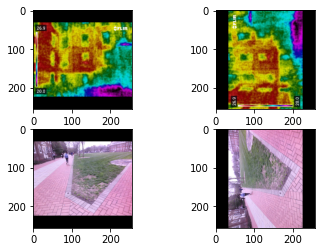

In [ ]:
#plot images and rotated images
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,2)
ax[0,0].imshow(thermal[0])
ax[0,1].imshow(rotated_thermal[0])
ax[1,0].imshow(gt[0])
ax[1,1].imshow(rotated_gt[0])

After rotation, we will have double amount of images, so that we need to group all thermal images and all RGB images toghter

In [ ]:
thermal_all = thermal + rotated_thermal
gt_all = gt + rotated_gt

In [ ]:
print(len(thermal_all)) #notice the number of images are doubled
print(len(gt_all))

1814
1814


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#use the below for the full data size, but the other one is for quicker testing
thermal_train, thermal_test, gt_train, gt_test = train_test_split(thermal_all, gt_all, test_size=0.2, random_state=42)
#thermal_train, thermal_test, gt_train, gt_test = train_test_split(thermal[0:100], gt[0:100], test_size=0.2, random_state=42)
print(f'There are {len(thermal_all)} thermal images and {len(gt_all)} RBG images.')  #these two number should be the same
print(f'The training set contains {len(thermal_train)} images, and the testing set contains {len(thermal_test)} images.') # the sum should add up to len(thermal)

There are 1814 thermal images and 1814 RBG images.
The training set contains 1451 images, and the testing set contains 363 images.


# Step 3: Build convolutional neural network from the tensorflow library

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

In [ ]:
# the input shape of neural network should be the same as the image size
in_shape = thermal[0].shape
print(in_shape)

(256, 256, 3)


In [ ]:
encoder = Sequential()
encoder.add(Conv2D(32, 3, strides=1, padding='same', activation='relu', input_shape=in_shape))
encoder.add(MaxPooling2D(2, strides=2))
encoder.add(Conv2D(64, 3, strides=1, padding='same', activation='relu'))
encoder.add(MaxPooling2D(2, strides=2))
encoder.add(Conv2D(128, 3, strides=1, padding='same', activation='relu'))
encoder.add(MaxPooling2D(2, strides=2))
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

In [ ]:
from keras.backend import conv2d_transpose
decoder = Sequential()
decoder.add(Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu', input_shape=encoder.output.shape[1:]))
decoder.add(Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'))
decoder.add(Conv2DTranspose(3, 3, strides=2, padding='same', activation='relu'))
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 16)     18448     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 256, 256, 3)      435       
 ranspose)                                                       
                                                                 
Total params: 166,467
Trainable params: 166,467
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_autoencoder = keras.Model(inputs=encoder.input, outputs=decoder(encoder.outputs))

In [ ]:
# specify the loss function we are using to train the model
loss_fn = tf.keras.losses.MeanSquaredError()
# compile the model
conv_autoencoder.compile(optimizer='adam', loss=loss_fn)

# Step 4: Training model

* Convert the data into tensorflow-compatible format
* The data is originally a list of images with size (256, 256, 3), but we want a numpy array of shape (length, 256, 256, 3)
* In order to do this, we stack images along the first dimension

In [ ]:
# convert training data
gt_train_ = np.stack(gt_train)
thermal_train_ = np.stack(thermal_train)
print(gt_train_.shape, thermal_train_.shape)

(1451, 256, 256, 3) (1451, 256, 256, 3)


In [ ]:
# convert testing data
gt_test_ = np.stack(gt_test)
thermal_test_ = np.stack(thermal_test)
print(gt_test_.shape, thermal_test_.shape)

(363, 256, 256, 3) (363, 256, 256, 3)


In [ ]:
from keras.callbacks import ModelCheckpoint #the function used to track trainiing process

In [ ]:
#create callback to track traning
filepath = 'best_everything_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
history = conv_autoencoder.fit(thermal_train_, gt_train_, batch_size=5, epochs=250, 
validation_data=(thermal_test_, gt_test_), callbacks=callbacks)  #play with batch size and epochs

Epoch 1/100
484/484 [==============================] - ETA: 0s - loss: 4241.0234
Epoch 1: val_loss improved from inf to 3804.22900, saving model to my_best_model.hdf5
484/484 [==============================] - 147s 303ms/step - loss: 4241.0234 - val_loss: 3804.2290
Epoch 2/100
484/484 [==============================] - ETA: 0s - loss: 3531.7720
Epoch 2: val_loss improved from 3804.22900 to 3287.58545, saving model to my_best_model.hdf5
484/484 [==============================] - 147s 304ms/step - loss: 3531.7720 - val_loss: 3287.5854
Epoch 3/100
484/484 [==============================] - ETA: 0s - loss: 3454.2520
Epoch 3: val_loss improved from 3287.58545 to 3281.38696, saving model to my_best_model.hdf5
484/484 [==============================] - 147s 303ms/step - loss: 3454.2520 - val_loss: 3281.3870
Epoch 4/100
484/484 [==============================] - ETA: 0s - loss: 3443.6885
Epoch 4: val_loss improved from 3281.38696 to 3218.41870, saving model to my_best_model.hdf5
484/484 [=====

* Plot the training process
* if the best model occurs in the middle of epochs, it is overfitting, otherwise, more traning epochs are needed.

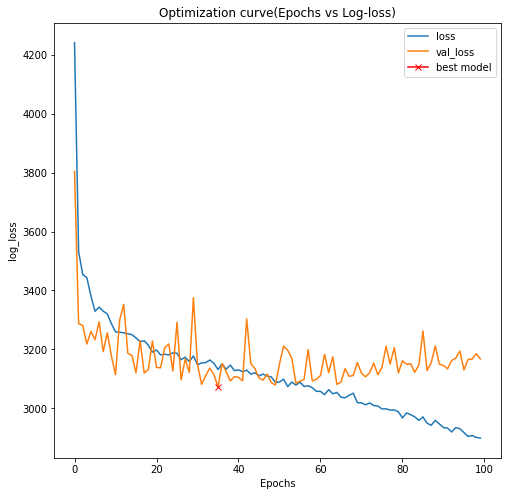

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Optimization curve(Epochs vs Log-loss)")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

# Step 5: Load the best model and use it to predict RGB images, compared with actral RGB images (ground truth)

In [ ]:
#Load the best model version
model = load_model(filepath)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer)  [(None, 256, 256, 3)]    0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       7385

In [ ]:
RGB_predicted = model.predict(thermal_test_)
print('Model MSE on test data = ', loss_fn(gt_test_, RGB_predicted).numpy())

Model MSE on test data =  3072.6494


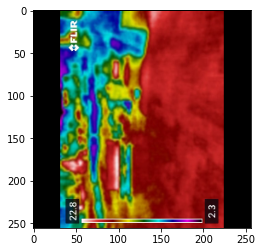

In [ ]:
plt.imshow(thermal_test_[27])
#print(type(thermal_test_[5]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


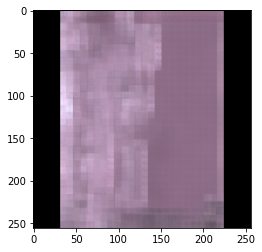

In [ ]:
plt.imshow(RGB_predicted[27]/255)

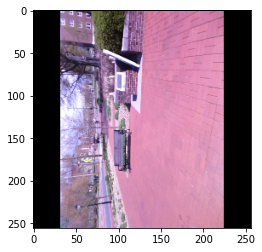

In [ ]:
plt.imshow(gt_test_[27])

In [ ]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img.astype(np.uint)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


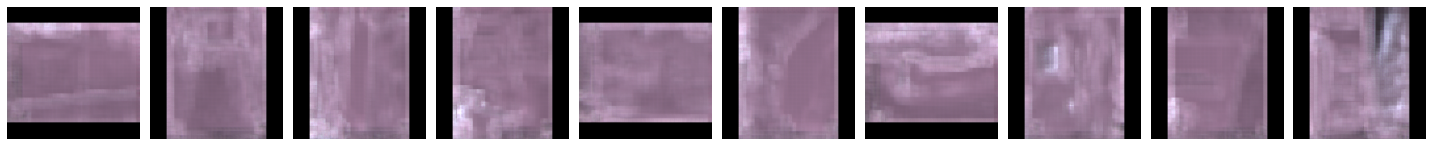

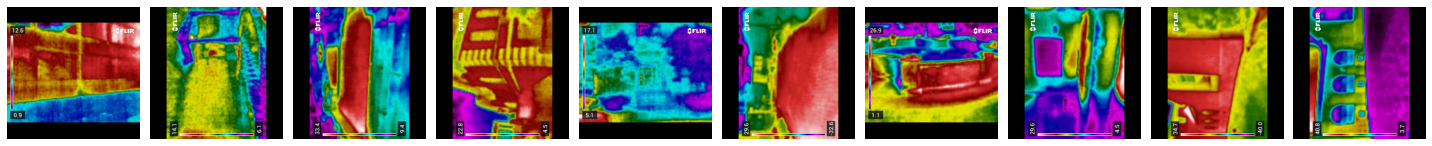

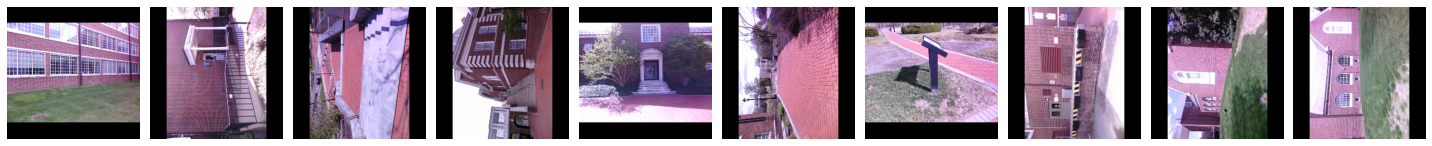

In [ ]:
plotImages(RGB_predicted[10:20])
plotImages(thermal_test_[10:20])
plotImages(gt_test_[10:20])